In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('hdb-price-with-features-2004to2013.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,shortest_dist_mall,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured
0,2012-02-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,85.0,...,0.824707,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1
1,2011-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,86.0,...,0.824707,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1
2,2011-12-01,BISHAN,5 ROOM,289,BISHAN ST 24,13 TO 15,121.0,Premium Apartment,1998,86.0,...,0.824707,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1
3,2011-11-01,BISHAN,4 ROOM,289,BISHAN ST 24,04 TO 06,102.0,Premium Apartment,1998,86.0,...,0.824707,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1
4,2011-09-01,BISHAN,5 ROOM,289,BISHAN ST 24,19 TO 21,121.0,Premium Apartment,1998,86.0,...,0.824707,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1


In [3]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [4]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [5]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI']) * 100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2012-02-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,85.0,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,94.491,756685.821930,2012
1,2011-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,86.0,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,93.877,637003.738935,2011
2,2011-12-01,BISHAN,5 ROOM,289,BISHAN ST 24,13 TO 15,121.0,Premium Apartment,1998,86.0,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,93.877,754178.339742,2011
3,2011-11-01,BISHAN,4 ROOM,289,BISHAN ST 24,04 TO 06,102.0,Premium Apartment,1998,86.0,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,93.842,610600.797084,2011
4,2011-09-01,BISHAN,5 ROOM,289,BISHAN ST 24,19 TO 21,121.0,Premium Apartment,1998,86.0,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,92.941,753165.987024,2011


In [6]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'distance_to_cbd_km',
       'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [7]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,distance_to_cbd_km,matured,adjusted_price,year
0,BISHAN,5 ROOM,07 TO 09,121.0,Premium Apartment,85.0,0.754215,1,0.824707,1,0.214393,1,3,7.635584,1,756685.821930,2012
1,BISHAN,4 ROOM,07 TO 09,100.0,Premium Apartment,86.0,0.754215,1,0.824707,1,0.214393,1,3,7.635584,1,637003.738935,2011
2,BISHAN,5 ROOM,13 TO 15,121.0,Premium Apartment,86.0,0.754215,1,0.824707,1,0.214393,1,3,7.635584,1,754178.339742,2011
3,BISHAN,4 ROOM,04 TO 06,102.0,Premium Apartment,86.0,0.754215,1,0.824707,1,0.214393,1,3,7.635584,1,610600.797084,2011
4,BISHAN,5 ROOM,19 TO 21,121.0,Premium Apartment,86.0,0.754215,1,0.824707,1,0.214393,1,3,7.635584,1,753165.987024,2011


In [8]:
# label encoding for Storey Range
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])


# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]

# label encoding for Storey Range and Flat Type
data = data.sort_values(by='flat_type')
data['flat_type'] = le.fit_transform(data['flat_type'])

In [9]:
data['flat_model'].value_counts()

Improved               62828
Model A                62204
New Generation         41364
Premium Apartment      16001
Simplified             12788
Standard               10560
Apartment               9397
Maisonette              6175
Model A2                4797
Adjoined flat            498
Model A-Maisonette       426
Terrace                  212
Improved-Maisonette       31
Premium Maisonette        30
2-room                    11
Name: flat_model, dtype: int64

In [10]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette',}
data = data.replace({'flat_model': replace_values})

# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]

In [11]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)

#### Check for Multicolinearity and VIF

C:\Users\tammy\AppData\Local\Temp\ipykernel_4408\2484217916.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


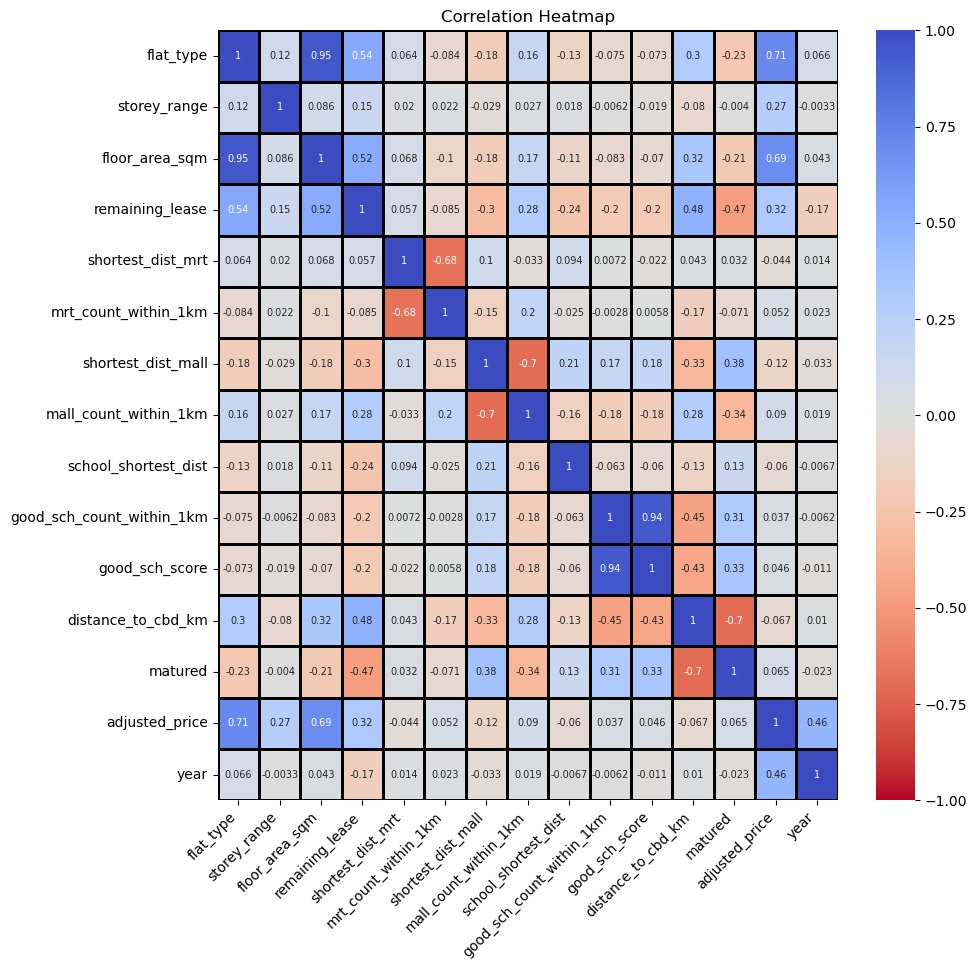

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int32','int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()


In [13]:
# Multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int32','int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,68.254745,0.014651,47.324459
1,storey_range,2.599521,0.384686,47.324459
2,floor_area_sqm,180.967483,0.005526,47.324459
3,remaining_lease,132.538896,0.007545,47.324459
4,shortest_dist_mrt,7.427009,0.134644,47.324459
5,mrt_count_within_1km,5.187240,0.192781,47.324459
6,shortest_dist_mall,7.930638,0.126093,47.324459
7,mall_count_within_1km,4.342560,0.230279,47.324459
8,school_shortest_dist,4.148283,0.241064,47.324459
9,good_sch_count_within_1km,12.872419,0.077685,47.324459


In [14]:
calc_vif(data.drop(['adjusted_price','mrt_count_within_1km','mall_count_within_1km','matured','good_sch_count_within_1km','flat_type','year'],axis=1).select_dtypes(include=['int32','int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.568087,0.389395,11.70252
1,floor_area_sqm,22.074042,0.045302,11.70252
2,remaining_lease,42.160714,0.023719,11.70252
3,shortest_dist_mrt,3.767161,0.265452,11.70252
4,shortest_dist_mall,3.934648,0.254152,11.70252
5,school_shortest_dist,3.657728,0.273394,11.70252
6,good_sch_score,1.672275,0.597988,11.70252
7,distance_to_cbd_km,13.785509,0.072540,11.70252


#### Performance Measure

In [15]:
def model_performance(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print('R^2 score =', r2)
    print('Test loss (MAE):', mae)
    
    
    return(r2, mae)
    

#### Model Building

#### Linear Regression

In [35]:
lr_df = data.drop(['mrt_count_within_1km','mall_count_within_1km','matured','good_sch_count_within_1km','flat_type','year'], axis=1)

In [36]:
X = lr_df.drop(['adjusted_price'], axis = 1)
y = np.log(lr_df['adjusted_price'])

In [37]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [38]:
continuous_columns = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']
    

train_scale_data = X_train[continuous_columns]
train_no_scale_data = X_train.drop(continuous_columns, axis = 1)

scaler = StandardScaler()
scaler.fit(train_scale_data)

scaled_train = scaler.transform(train_scale_data)
scaled_train = pd.DataFrame(scaled_train, index = train_scale_data.index ,columns= continuous_columns)
X_train = pd.concat([scaled_train,train_no_scale_data], axis=1)


test_scale_data = X_test[continuous_columns]
test_no_scale_data = X_test.drop(continuous_columns, axis = 1)

scaled_test = scaler.transform(test_scale_data)
scaled_test = pd.DataFrame(scaled_test, index = test_scale_data.index ,columns= continuous_columns)
X_test = pd.concat([scaled_test,test_no_scale_data], axis=1)

In [39]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae = model_performance(lr)

R^2 score = 0.6675238972331021
Test loss (MAE): 0.15888490240356617


In [40]:
# if remove year
#R^2 score = 0.6675238972331021
#Test loss (MAE): 0.15888490240356617

# if keep year
# R^2 score = 0.8786545461139986
# Test loss (MAE): 0.08883246727760924

In [21]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,0.381703
13,town_BUKIT TIMAH,0.332904
0,floor_area_sqm,0.273982
11,town_BUKIT MERAH,0.170864
38,flat_model_Premium Apartment,0.166966
36,flat_model_Model A2,0.157888
24,town_PUNGGOL,0.122196
14,town_CENTRAL AREA,0.118479
9,town_BISHAN,0.111305
25,town_QUEENSTOWN,0.098657


In [22]:
X_constant = sm.add_constant(X)
lr = sm.OLS(y,X_constant).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 1.112e+04
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:07:42   Log-Likelihood:                 55495.
No. Observations:              226601   AIC:                        -1.109e+05
Df Residuals:                  226559   BIC:                        -1.105e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Random Forest

In [41]:
X = data.drop(['adjusted_price'], axis = 1)
y = np.log(data['adjusted_price'])

In [42]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [43]:
continuous_columns = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']
    

train_scale_data = X_train[continuous_columns]
train_no_scale_data = X_train.drop(continuous_columns, axis = 1)

scaler = StandardScaler()
scaler.fit(train_scale_data)

scaled_train = scaler.transform(train_scale_data)
scaled_train = pd.DataFrame(scaled_train, index = train_scale_data.index ,columns= continuous_columns)
X_train = pd.concat([scaled_train,train_no_scale_data], axis=1)


test_scale_data = X_test[continuous_columns]
test_no_scale_data = X_test.drop(continuous_columns, axis = 1)

scaled_test = scaler.transform(test_scale_data)
scaled_test = pd.DataFrame(scaled_test, index = test_scale_data.index ,columns= continuous_columns)
X_test = pd.concat([scaled_test,test_no_scale_data], axis=1)

In [44]:
rf = RandomForestRegressor()
rf_r2, rf_mae = model_performance(rf)

R^2 score = 0.9527841763381694
Test loss (MAE): 0.0520257610991403


In [45]:
rf_importance = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
0,floor_area_sqm,0.442751
13,year,0.221566
6,flat_type,0.130313
5,distance_to_cbd_km,0.086028
1,remaining_lease,0.024106
2,shortest_dist_mrt,0.023398
3,shortest_dist_mall,0.014488
7,storey_range,0.013660
12,matured,0.012121
4,school_shortest_dist,0.008978


#### XGBoost

In [46]:
xgb = XGBRegressor()
xgb_r2, xgb_mae = model_performance(xgb)

R^2 score = 0.9556589769890713
Test loss (MAE): 0.05154874305563061


In [47]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
6,flat_type,0.528939
0,floor_area_sqm,0.091328
13,year,0.072937
12,matured,0.062947
37,town_WOODLANDS,0.028283
28,town_MARINE PARADE,0.023719
15,town_BISHAN,0.015046
5,distance_to_cbd_km,0.013648
17,town_BUKIT MERAH,0.012713
19,town_BUKIT TIMAH,0.012436


#### Out-of-Bag

In [49]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae = model_performance(oob_model)

R^2 score = 0.9526876081777789
Test loss (MAE): 0.052052454890039644


In [50]:
oob_importance = pd.DataFrame(list(zip(X_train.columns, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
0,floor_area_sqm,0.442938
13,year,0.221690
6,flat_type,0.129898
5,distance_to_cbd_km,0.086069
1,remaining_lease,0.024291
2,shortest_dist_mrt,0.023407
3,shortest_dist_mall,0.014375
7,storey_range,0.013672
12,matured,0.012296
4,school_shortest_dist,0.008826
